# VAE and VSC for Cell Images

In [14]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from torch import cuda
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils import data
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from PIL import Image

In [15]:
data_dir = '../../../Data/'
results_dir = '../../../results/VSC/z256a0.5c50b1e100'
tensorboard_dir = '../../../tb/VSC'
metadata_dir = '../../../metadata/'
batch_size = 128

tb_writer = SummaryWriter(tensorboard_dir)

torch.manual_seed(22)
device = torch.device("cuda" if cuda.is_available() else "cpu")
print(device)

cuda


The following code is a utility to load and split the data given the path where the data is stored, pytorch keeps the folder names as labes as if it was a classification task, but they can just be ignored when using the data loaders. Since the task at hand is from a very specific domain (biology and cell images) the normalization values that are often used for computer vision tasks cannot be used. The mean and std used to normalize the dataset was pre computed from a small sample of the dataset and might not be accurate, but it seems to work well right now

In [16]:
def split_data(data_dir, n_split=0.2, batch_size=256):
    
    pin_memory = cuda.is_available()
    workers = 4
    
    # Create training and validation datasets
    image_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        transforms.Normalize((0.0302, 0.0660, 0.0518), (0.0633, 0.0974, 0.0766))
    ]))
    # Create training and validation dataloaders
    total = len(image_dataset)
    n_test = int(total * n_split)
    n_train = total - n_test 
    train_set, test_set = data.random_split(image_dataset, (n_train, n_test))
    n_val = int(len(train_set) * n_split)
    n_train = len(train_set) - n_val
    train_set, val_set = data.random_split(train_set, (n_train, n_val))  
    
    print('Train split: ', len(train_set))
    print('Val split: ', len(val_set))
    print('Test split: ', len(test_set))
    
    train_loader = data.DataLoader(
      train_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    val_loader = data.DataLoader(
      val_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    test_loader = data.DataLoader(
      test_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    return train_loader, val_loader, test_loader, image_dataset.class_to_idx

Helper function to view tensors as a plot

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.0302, 0.0660, 0.0518])
    std = np.array([0.0633, 0.0974, 0.0766])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [18]:
def grid_and_unnormalize(batch_tensor):
    grid = torchvision.utils.make_grid(batch_tensor)
    image = grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.0302, 0.0660, 0.0518])
    std = np.array([0.0633, 0.0974, 0.0766])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

## Variational AutoEncoder

The previous work this is based on had an specific VAE architecture implemented in TensorFlow, the first step was to migrate that NN to Pytorch keeping the same layers and the same operations that were done in the encoder and autoencoder, as well as to keep the same loss fuction

In [19]:
# With new stuff we just have to import the files
import sys
sys.path.insert(0, '../scripts/')
import vae
import vsc

From what I've seen MSE and KLD and somewhat incompatible depending on how the scores are aggregated. It either has to be sum or mean, choosing different aggregation techniques results in the difference between scores being too different and the NN will end up optimizing the one that has the bigger impact. Current solution is B-Vae where a B parameter is added to the KLD as to control how much importance it has in the loss function; KLD and MSE are aggregated by sum.

In [20]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, epoch_n=False):
    
    # mse = F.mse_loss(recon_x, x, reduction='mean')
     
    mse = torch.mean(torch.sum((x - recon_x).pow(2), dim=(1,2,3)))
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    
    #kld = torch.mean(-0.5 * torch.sum(1 + torch.log(1e-10 + sigma.pow(2)) - mu.pow(2) - sigma.pow(2)))
    #kld = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), axis=1))
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * beta
    
    loss = mse + kld
    return loss, mse, kld

Helpers for the model training and testing loop 

In [21]:
def train(epoch, train_loader):
    model.train()
    train_loss = 0
    train_mse = 0
    train_kld = 0
    train_slab = 0
    train_spike = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, gamma = model(data)
        loss, mse, kld, slab, spike = loss_function(recon_batch, data, mu, logvar, gamma, alpha=alpha, beta=beta)
        
        loss.backward()
        optimizer.step()
        
        current_batch_size = len(data)
        train_loss += loss.item() * current_batch_size
        train_mse += mse.item() * current_batch_size
        train_kld += kld.item()
        train_slab += slab.item()
        train_spike += spike.item()
        
        if batch_idx % (int(len(train_loader) / 4)) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()))

    datapoints = len(train_loader.dataset)
    avg_loss = train_loss/datapoints
    avg_mse = train_mse/datapoints
    avg_kld = train_kld/(beta * len(train_loader))
    avg_slab = train_slab/(beta * len(train_loader))
    avg_spike = train_spike/(beta * len(train_loader))

    print('====> Epoch: {} Average loss: {:.8f}'.format(epoch, avg_loss))
    print('*** Avg MSE: {:.4f}'.format(avg_mse))
    print('*** Avg KLD: {:.8f}'.format(avg_kld * beta))
    print('* Avg Slab: {:.8f}'.format(avg_slab * beta))
    print('* Avg Spike: {:.8f}'.format(avg_spike * beta))
    return avg_loss, avg_mse, avg_kld, avg_slab, avg_spike

In [22]:
def test(epoch, test_loader):
    model.eval()
    test_loss = 0
    test_mse = 0
    test_kld = 0
    test_slab = 0
    test_spike = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar, gamma = model(data)
            loss, mse, kld, slab, spike = loss_function(recon_batch, data, mu, logvar, gamma, alpha=alpha, beta=beta)

            current_batch_size = data.size(0)
            test_loss += loss.item() * current_batch_size
            test_mse += mse.item() * current_batch_size
            test_kld += kld.item()
            test_slab += slab.item()
            test_spike += spike.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch[:n]]).cpu()
                image = grid_and_unnormalize(comparison)
                comparison = torchvision.utils.make_grid(comparison)
                imshow(comparison)
                
                tb_writer.add_image("Reconstruction/recon_"+str(epoch), image, epoch, dataformats='HWC')
                
                plt.savefig(results_dir + 'reconstruction_' + str(epoch) + '.png')
                plt.close()
                #save_image(comparison, results_dir + 'reconstruction_' + str(epoch) + '.tif')

    datapoints = len(test_loader.dataset)
    test_loss /= datapoints
    test_mse /= datapoints
    test_kld /= (beta * len(test_loader))
    test_slab /= (beta * len(test_loader))
    test_spike /= (beta * len(test_loader))
    print('====> Test set loss: {:.8f}'.format(test_loss))
    print('*** Avg MSE: {:.8f}'.format(test_mse))
    print('*** Avg KLD: {:.8f}'.format(test_kld))
    print('* Avg Slab: {:.8f}'.format(test_slab * beta))
    print('* Avg Spike: {:.8f}'.format(test_spike * beta))
    return test_loss, test_mse, test_kld, test_slab, test_spike

In [23]:
def get_time_in_hours(seconds):
    hours = seconds // 3600
    remaining_time = seconds % 3600
    minutes = remaining_time // 60
    seconds = remaining_time % 60
    
    return hours, minutes, seconds

### Training
The training of the migrated VAE starts here

In [24]:
train_data, val_data, test_data, label_mapping = split_data(data_dir=data_dir, batch_size=batch_size)

Train split:  97014
Val split:  24253
Test split:  30316


In [25]:
alpha = 0.5
beta = 1
c = 50
model = vsc.VSC(256, c).to(device)
loss_function = vsc.loss_function
model

VSC(
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten()
  (encoder_fc1): Linear(in_features=4608, out_features=256, bias=True)
  (encoder_fc2): Linear(in_features=4608, out_features=256, bias=True)
  (encoder_fc3): Linear(in_features=4608, out_features=256, bias=True)
  (encoder_sigmoid): Sigmoid()
  (reparam_sigmoid): Sigmoid()
  (decoder_fc1): Sequential(
    (0): Linear(in_features=256, out_

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_trace = {
    'loss': [],
    'mse': [],
    'kld': [],
    'slab': [],
    'spike': []
}

val_trace = {
    'loss': [],
    'mse': [],
    'kld': [],
    'slab': [],
    'spike': []
}
epochs = 100
since = time.time()
for epoch in range(1, epochs + 1):
        train_loss, train_mse, train_kld, train_slab, train_spike = train(epoch, train_data)
        train_trace['loss'].append(train_loss)
        train_trace['mse'].append(train_mse)
        train_trace['kld'].append(train_kld)
        train_trace['slab'].append(train_slab)
        train_trace['spike'].append(train_spike)

        val_loss, val_mse, val_kld, val_slab, val_spike = test(epoch, val_data)
        val_trace['loss'].append(val_loss)
        val_trace['mse'].append(val_mse)
        val_trace['kld'].append(val_kld)
        val_trace['slab'].append(val_slab)
        val_trace['spike'].append(val_spike)
        c += 1
        print('Updating C. c=',c)
        model.update_c(c)
        tb_writer.add_scalars('Loss/Total', {
            'train': train_loss,
            'test': val_loss
        }, epoch)
        
        tb_writer.add_scalars('Loss/MSE', {
            'train': train_mse,
            'test': val_mse
        }, epoch)
        
        tb_writer.add_scalars('Loss/KLD', {
            'train': train_kld,
            'test': val_kld
        }, epoch)
        
        tb_writer.add_scalars('Loss/Slab', {
            'train': train_slab,
            'test': val_slab
        }, epoch)
        
        tb_writer.add_scalars('Loss/Spike', {
            'train': train_spike,
            'test': val_spike
        }, epoch)
        
        with torch.no_grad():
            sample = torch.randn(4, 256).to(device)
            sample = model.decode(sample).cpu()
            image = grid_and_unnormalize(sample)
            sample = torchvision.utils.make_grid(sample)
            tb_writer.add_image("Sample/sample_"+str(epoch), image, epoch, dataformats='HWC')
            imshow(sample)
            plt.savefig(results_dir + 'sample_' + str(epoch) + '.png')
            plt.close()
            #save_image(sample, results_dir + 'sample_' + str(epoch) + '.tif')
        
        epoch_time = time.time() - since
        e_hours, e_minutes, e_seconds = get_time_in_hours(epoch_time)
        print('Time elapsed {:.0f}h {:.0f}m {:.0f}s'.format(e_hours, e_minutes, e_seconds))

Train Epoch: 1 [0/97014 (0%)]	Loss: 4719770.500000
Train Epoch: 1 [24192/97014 (25%)]	Loss: 1714314.875000
Train Epoch: 1 [48384/97014 (50%)]	Loss: 1447632.250000
Train Epoch: 1 [72576/97014 (75%)]	Loss: 1237377.375000
Train Epoch: 1 [96768/97014 (100%)]	Loss: 1357869.750000
====> Epoch: 1 Average loss: 1613307.23644783
*** Avg MSE: 1544240.3922
*** Avg KLD: 69066.38929483
* Avg Slab: 52435.32478004
* Avg Spike: 16631.06470593
====> Test set loss: 1173106.32766050
*** Avg MSE: 1099457.80711407
*** Avg KLD: 73543.83098273
* Avg Slab: 53802.66803043
* Avg Spike: 19741.16336863
Updating C. c= 51
Time elapsed 0h 2m 7s
Train Epoch: 2 [0/97014 (0%)]	Loss: 1247928.750000
Train Epoch: 2 [24192/97014 (25%)]	Loss: 1104477.750000
Train Epoch: 2 [48384/97014 (50%)]	Loss: 951970.187500
Train Epoch: 2 [72576/97014 (75%)]	Loss: 1039534.250000
Train Epoch: 2 [96768/97014 (100%)]	Loss: 908555.187500
====> Epoch: 2 Average loss: 1103905.49211454
*** Avg MSE: 1028185.6010
*** Avg KLD: 75719.34272963
* Av

Train Epoch: 14 [72576/97014 (75%)]	Loss: 728086.250000
Train Epoch: 14 [96768/97014 (100%)]	Loss: 906657.250000
====> Epoch: 14 Average loss: 871350.86839786
*** Avg MSE: 794744.5652
*** Avg KLD: 76605.64191334
* Avg Slab: 56875.23087071
* Avg Spike: 19730.41100140
====> Test set loss: 876042.85237393
*** Avg MSE: 799184.15782068
*** Avg KLD: 76746.51457648
* Avg Slab: 56832.03022204
* Avg Spike: 19914.48426706
Updating C. c= 64
Time elapsed 0h 30m 42s
Train Epoch: 15 [0/97014 (0%)]	Loss: 1026644.000000
Train Epoch: 15 [24192/97014 (25%)]	Loss: 999648.250000
Train Epoch: 15 [48384/97014 (50%)]	Loss: 961461.812500
Train Epoch: 15 [72576/97014 (75%)]	Loss: 795447.812500
Train Epoch: 15 [96768/97014 (100%)]	Loss: 883905.687500
====> Epoch: 15 Average loss: 865396.81558203
*** Avg MSE: 788881.4016
*** Avg KLD: 76514.73821941
* Avg Slab: 56804.07341483
* Avg Spike: 19710.66479685
====> Test set loss: 868166.83433622
*** Avg MSE: 791799.95689193
*** Avg KLD: 76255.61344572
* Avg Slab: 56692

In [14]:
def plot_loss(train_data, val_data, epochs, xlabel, ylabel, title):
    plt.figure(figsize=(10,10))
    
    min_train = int(min(train_data))
    max_train = int(max(train_data))
    min_val = int(min(val_data))
    max_val = int(max(val_data))
    
    low_bound = min(min_train, min_val)
    up_bound = max(max_train, max_val)
    
    plt.plot(train_data, label='train')
    plt.plot(val_data, label='test')
    plt.xticks(np.arange(0, epochs+1, int(epochs/20)))
    plt.yticks(np.arange(low_bound, up_bound*1.01, int((1.1*up_bound - 1.1*low_bound) / 20)))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

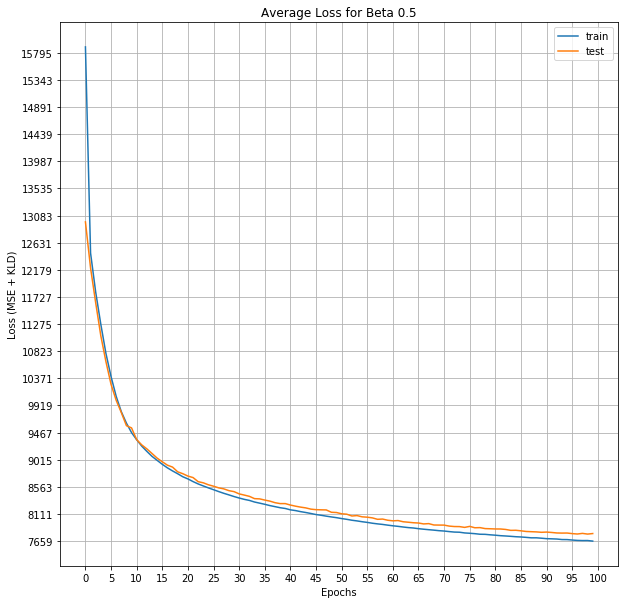

In [15]:
plot_loss(train_trace['loss'], val_trace['loss'], epochs, 'Epochs', "Loss (MSE + KLD)", "Average Loss for Beta " + str(beta))

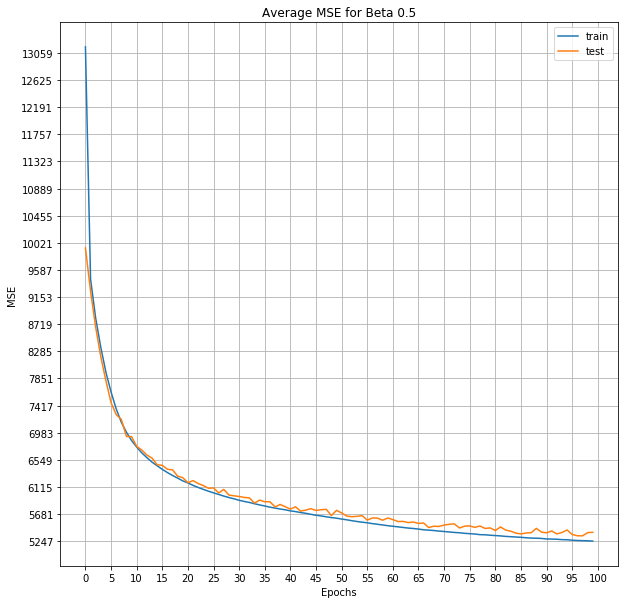

In [16]:
plot_loss(train_trace['mse'], val_trace['mse'], epochs, 'Epochs', "MSE", "Average MSE for Beta " + str(beta))

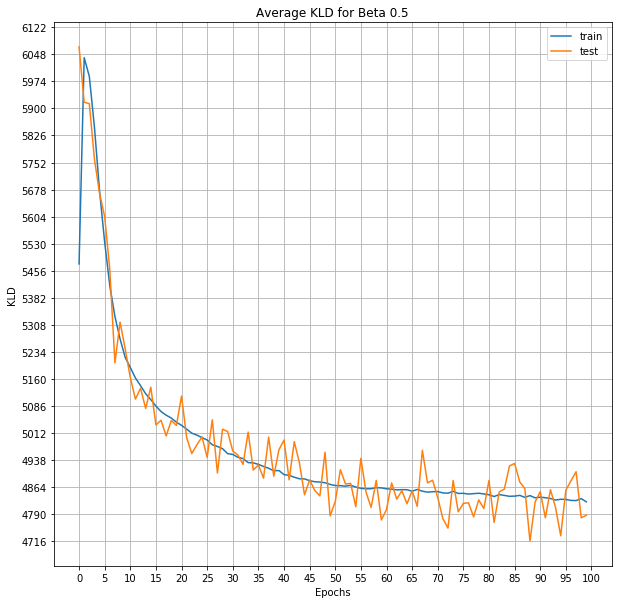

In [17]:
plot_loss(train_trace['kld'], val_trace['kld'], epochs, 'Epochs', "KLD", "Average KLD for Beta " + str(beta))

In [18]:
torch.save(model.state_dict(), results_dir + 'vae.pth')

In [12]:
model = VAE(256)
model.load_state_dict(torch.load(results_dir + 'vae.pth'))
model.to(device)
model.eval()

VAE(
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten()
  (encoder_fc1): Linear(in_features=4608, out_features=256, bias=True)
  (encoder_fc2): Linear(in_features=4608, out_features=256, bias=True)
  (decoder_fc1): Sequential(
    (0): Linear(in_features=256, out_features=4608, bias=True)
    (1): ReLU()
  )
  (decoder_upsampler1): Upsample(scale_factor=(2.0, 2.0), mode=nearest)
  (decoder_deco

## Evaluation

In [13]:
metadata = pd.read_csv(metadata_dir + 'compound_to_cell.csv')
metadata['Image_FileName_DAPI'] = metadata['Image_FileName_DAPI'].apply(lambda x: x.split('.tif')[0])
metadata.head(5)

,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration
0,4,233,G10_s1_w1BEDC2073-A983-4B98-95E9-84466707A25D,Week4/Week4_27481,G10_s1_w2DCEC82F3-05F7-4F2F-B779-C5DF9698141E.tif,Week4/Week4_27481,G10_s1_w43CD51CBC-2370-471F-BA01-EE250B14B3C8.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003
1,4,234,G10_s2_w11C3B9BCC-E48F-4C2F-9D31-8F46D8B5B972,Week4/Week4_27481,G10_s2_w2570437EF-C8DC-4074-8D63-7FA3A7271FEE.tif,Week4/Week4_27481,G10_s2_w400B21F33-BDAB-4363-92C2-F4FB7545F08C.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003
2,4,235,G10_s3_w1F4FCE330-C71C-4CA3-9815-EAF9B9876EB5,Week4/Week4_27481,G10_s3_w2194A9AC7-369B-4D84-99C0-DA809B0042B8.tif,Week4/Week4_27481,G10_s3_w4E0452054-9FC1-41AB-8C5B-D0ACD058991F.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003
3,4,236,G10_s4_w1747818B4-FFA7-40EE-B0A0-6A5974AF2644,Week4/Week4_27481,G10_s4_w298D4652F-B5BF-49F2-BE51-8149DF83EAFD.tif,Week4/Week4_27481,G10_s4_w42648D36D-6B77-41CD-B520-6E4C533D9ABC.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003
4,4,473,G10_s1_w10034568D-CC12-43C3-93A9-DC3782099DD3,Week4/Week4_27521,G10_s1_w2A29ED14B-952C-4BA1-89B9-4F92B6DADEB4.tif,Week4/Week4_27521,G10_s1_w4DAA2E9D1-F6E9-45FA-ADC0-D341B647A680.tif,Week4/Week4_27521,Week4_27521,G10,2,5-fluorouracil,0.003


In [14]:
test_z = None
test_labels = None
for data, labels in test_data:
    data = data.to(device)
    encoded = model.encode(data)
    batch_z = model.reparameterize(*encoded).cpu().detach()
    if test_z is not None:
        test_z = torch.cat((test_z, batch_z), dim=0)
        test_labels = torch.cat((test_labels, labels))
    else:
        test_z = batch_z
        test_labels = labels


In [15]:
compound_folder = metadata[['Image_FileName_DAPI', 'Image_Metadata_Compound']].sort_values('Image_FileName_DAPI')
cf_id = compound_folder['Image_FileName_DAPI'].apply(lambda x: int(label_mapping.get(x, -1)))
compound_folder['id'] = cf_id
compound_folder = compound_folder[compound_folder.id != -1]
compound_folder

,Image_FileName_DAPI,Image_Metadata_Compound,id
12408,B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10,DMSO,0
12504,B02_s1_w1B1A7ADEA-8896-4C7D-8C63-663265374B72,DMSO,1
12456,B02_s1_w1D9CCD4E7-65E8-4426-9178-A955453164C5,DMSO,2
12432,B02_s1_w1E35EFE33-AB1C-4DB4-996B-D224E67F5C72,DMSO,3
12480,B02_s1_w1EA42BBDC-A8FA-44AB-A9B7-DA330F81E2A2,DMSO,4
...,...,...,...
12499,F11_s4_w1423324D8-4DCA-4A5B-80F9-CEAA52425281,DMSO,902
12475,F11_s4_w15D4C00DF-F9F2-4C86-943F-52A5F80508D2,DMSO,903
12403,F11_s4_w16E9FF291-D2C4-48E3-B076-CBD2A71FE95D,DMSO,904
12523,F11_s4_w1AA58D79B-0601-443D-A27C-7E5B61E4DB1C,DMSO,905


In [16]:
def compound_mean(compound):
    selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == compound]
    is_compound = np.isin(test_labels, selected_comps.id.values)
    comp_matrix = test_z[is_compound].numpy()
    #covar = np.cov(comp_matrix.T)
    mean = np.mean(comp_matrix, axis=0)
    mean = mean.reshape(256,1)
    return mean

def mahalanobis_dist(x, y, covar): 
    delta = x - y
    mahalanobis = delta.T @ np.linalg.inv(covar) @ delta
    mahalanobis = np.sqrt(mahalanobis)
    return np.diag(mahalanobis)[0]

In [17]:
np.cov(test_z.numpy().T).shape

(256, 256)

In [18]:
comp_list = compound_folder['Image_Metadata_Compound'].unique()
mc_cache = {}
covar = np.cov(test_z.numpy().T)
dist_matrix = np.empty(0)
for base in comp_list:
    distances = []
    base_mean = None
    
    if base in mc_cache.keys():
        base_mean = mc_cache[base]
    else:
        base_mean = compound_mean(base)
        mc_cache[base] = base_mean
        
    for target in comp_list: 
        target_mean = None
        target_covar = None
        
        if target in mc_cache.keys():
            target_mean = mc_cache[target]
        else:
            target_mean = compound_mean(target)
            mc_cache[target] = target_mean
        
        mahalanobis = mahalanobis_dist(base_mean, target_mean, covar)
        distances.append(mahalanobis)
        
    dist_array = np.array(distances)
    
    if dist_matrix.any():
        dist_matrix = np.vstack((dist_matrix, dist_array))
    else:
        dist_matrix = dist_array
        
dist_matrix.shape

(12, 12)

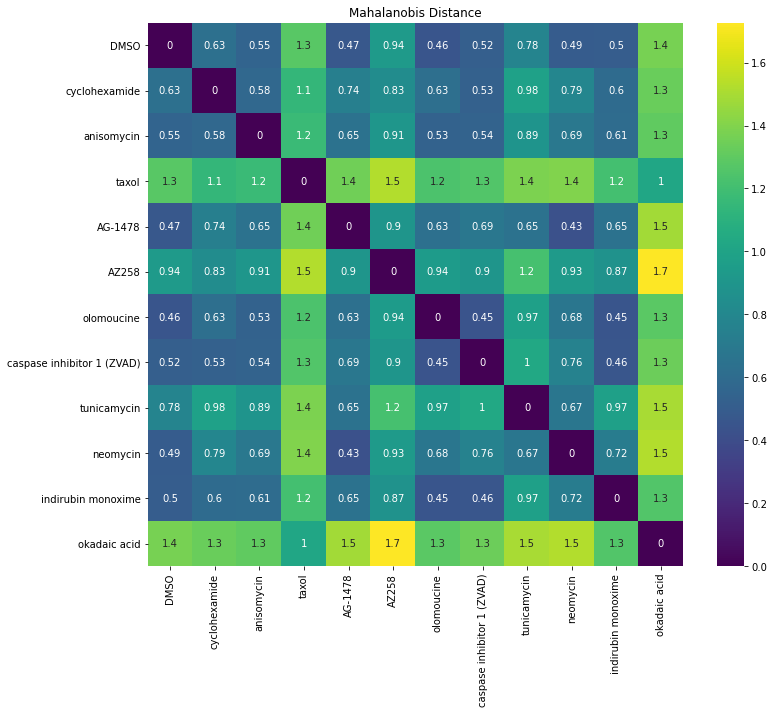

In [19]:
plt.figure(figsize=(12,10))
sns.heatmap(dist_matrix, xticklabels=comp_list, yticklabels=comp_list, cmap=plt.cm.viridis, annot=True)
plt.title('Mahalanobis Distance')
plt.show()

In [20]:
def std_matrix(x):
    sigma = np.eye(len(x[0]))
    std = np.std(x, axis=0)
    np.fill_diagonal(sigma, std)
    return sigma

def kl_distance(x, y):
    sigma_x = std_matrix(x)
    sigma_y = std_matrix(y)
    d = len(x[0])
    mu_x = np.mean(x, axis=0)
    mu_y = np.mean(y, axis=0)
    
    kl = np.trace(np.linalg.inv(sigma_y) @ sigma_x)
    kl += ((mu_y - mu_x).T @ np.linalg.inv(sigma_y) @ (mu_y - mu_x)) - d
    kl += np.log(np.linalg.det(sigma_y) / np.linalg.det(sigma_x))
    return kl

def symmetric_kl(x, y):
    kl_xy = kl_distance(x, y)
    kl_yx = kl_distance(y, x)
    
    return 0.5 * (kl_xy + kl_yx)

In [21]:
kldist_matrix = np.empty(0)
i = 0
for x in comp_list:
    distances = []
    selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == x]
    is_compound = np.isin(test_labels, selected_comps.id.values)
    comp_x = test_z[is_compound].numpy()
    for y in comp_list:
        selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == y]
        is_compound = np.isin(test_labels, selected_comps.id.values)
        comp_y = test_z[is_compound].numpy()
        distances.append(symmetric_kl(comp_x, comp_y))
        
    dist_array = np.array(distances)
    if kldist_matrix.any():
        kldist_matrix = np.vstack((kldist_matrix, dist_array))
    else:
        kldist_matrix = dist_array
kldist_matrix.shape

(12, 12)

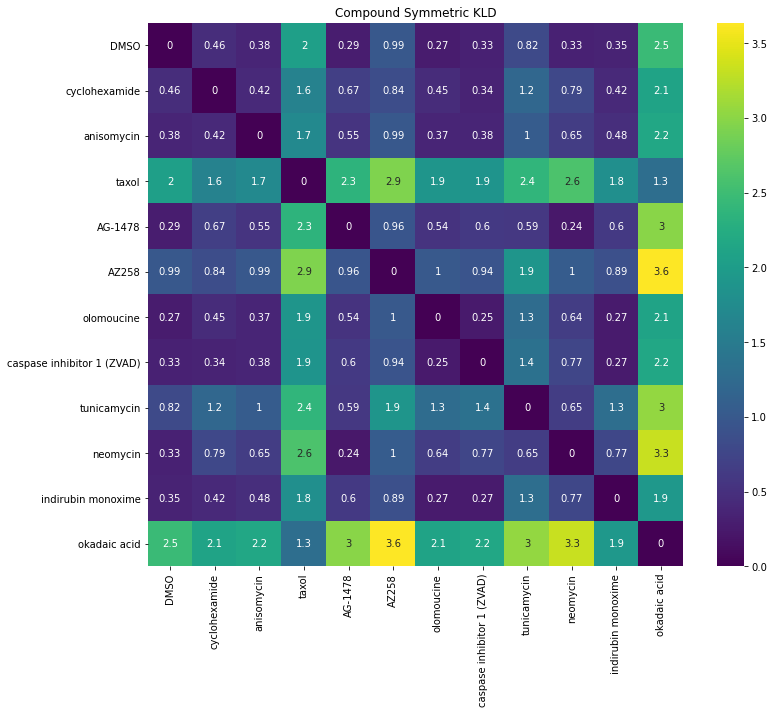

In [22]:
plt.figure(figsize=(12,10))
sns.heatmap(kldist_matrix, xticklabels=comp_list, yticklabels=comp_list, cmap=plt.cm.viridis, annot=True)
plt.title('Compound Symmetric KLD')
plt.show()

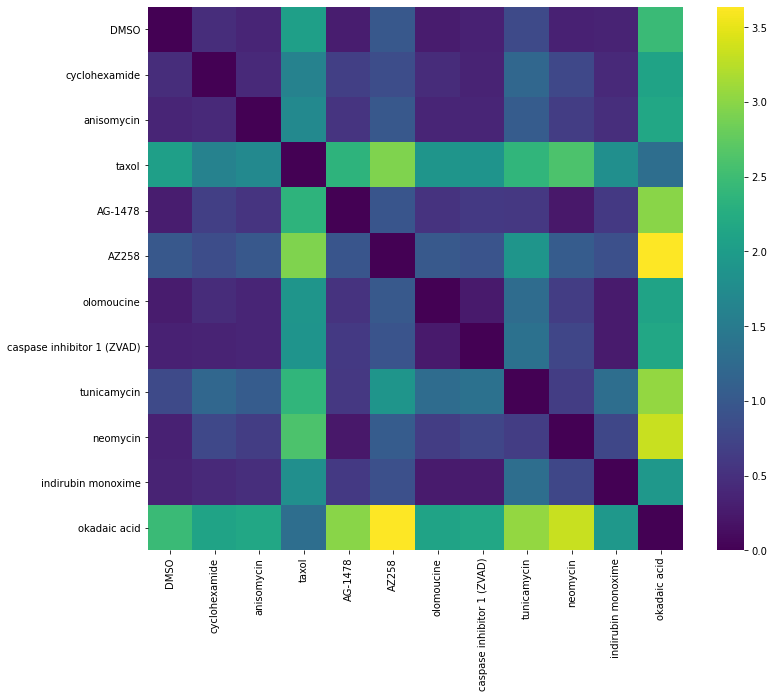

In [29]:
fig = plt.figure(figsize=(12,10))
hm = sns.heatmap(kldist_matrix, xticklabels=comp_list, yticklabels=comp_list, cmap=plt.cm.viridis, )
figname = results_dir + 'Eval_kld.png'
hm.figure.savefig(figname)

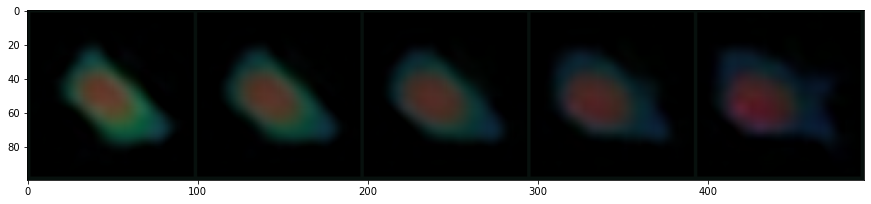

In [65]:
model.eval()
idx = np.argmax(kldist_matrix)
s, _ = kldist_matrix.shape
comp_a = idx // s
comp_b = idx % s
comp_a = comp_list[comp_a]
comp_b = comp_list[comp_b]

selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == comp_a]
is_compound = np.isin(test_labels, selected_comps.id.values)
comp_arr_a = test_z[is_compound].numpy()

selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == comp_b]
is_compound = np.isin(test_labels, selected_comps.id.values)
comp_arr_b = test_z[is_compound].numpy()

np.random.seed(22)
base_idx = np.random.randint(len(comp_arr_a))
target_idx = np.random.randint(len(comp_arr_b))

base = torch.from_numpy(comp_arr_a[base_idx:base_idx+1]).to(device)
target = torch.from_numpy(comp_arr_b[target_idx:target_idx+1]).to(device)

diff = target - base
recon_25 = model.decode(base + diff*0.25)
recon_50 = model.decode(base + diff*0.50)
recon_75 = model.decode(base + diff*0.75)
base = model.decode(base)
target = model.decode(target)
interpolation = torch.cat((base, recon_25, recon_50, recon_75, target), dim=0).cpu().detach()
plt.figure(figsize=(15,15))
imshow(torchvision.utils.make_grid(interpolation))

In [ ]:
test_compounds = []

for label in test_labels:
    compound = compound_folder[compound_folder.id == label.item()]['Image_Metadata_Compound'].values[0]
    test_compounds.append(compound)

test_compounds

In [21]:
compound_folder['Image_Metadata_Compound'].value_counts()

DMSO                          100
neomycin                       89
olomoucine                     82
caspase inhibitor 1 (ZVAD)     82
indirubin monoxime             82
tunicamycin                    78
AG-1478                        76
cyclohexamide                  72
AZ258                          69
okadaic acid                   67
taxol                          58
anisomycin                     52
Name: Image_Metadata_Compound, dtype: int64

In [22]:
dmso = compound_folder[compound_folder['Image_Metadata_Compound'] == 'DMSO']
dmso

,Image_FileName_DAPI,Image_Metadata_Compound,id
12408,B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10,DMSO,0
12504,B02_s1_w1B1A7ADEA-8896-4C7D-8C63-663265374B72,DMSO,1
12456,B02_s1_w1D9CCD4E7-65E8-4426-9178-A955453164C5,DMSO,2
12432,B02_s1_w1E35EFE33-AB1C-4DB4-996B-D224E67F5C72,DMSO,3
12480,B02_s1_w1EA42BBDC-A8FA-44AB-A9B7-DA330F81E2A2,DMSO,4
...,...,...,...
12499,F11_s4_w1423324D8-4DCA-4A5B-80F9-CEAA52425281,DMSO,902
12475,F11_s4_w15D4C00DF-F9F2-4C86-943F-52A5F80508D2,DMSO,903
12403,F11_s4_w16E9FF291-D2C4-48E3-B076-CBD2A71FE95D,DMSO,904
12523,F11_s4_w1AA58D79B-0601-443D-A27C-7E5B61E4DB1C,DMSO,905


In [24]:
len(test_labels)

30316

In [25]:
categorical_labels = pd.Series(test_compounds, dtype="category")
categorical_labels

0        caspase inhibitor 1 (ZVAD)
1                              DMSO
2                             taxol
3                        anisomycin
4        caspase inhibitor 1 (ZVAD)
                    ...            
30311                      neomycin
30312                          DMSO
30313                          DMSO
30314                      neomycin
30315    caspase inhibitor 1 (ZVAD)
Length: 30316, dtype: category
Categories (12, object): [AG-1478, AZ258, DMSO, anisomycin, ..., okadaic acid, olomoucine, taxol, tunicamycin]

In [202]:
tb_writer.add_embedding(test_z, global_step=100, tag='Latent space')

In [121]:
import umap
reducer = umap.UMAP(random_state=22)
z_2d = reducer.fit_transform(test_z)

In [122]:
from ipywidgets import widgets, interactive

# Make a dropdown to select the Area, or "All"
comp = widgets.Dropdown(
    options=['All'] + list(compound_folder['Image_Metadata_Compound'].unique()),
    value='All',
    description='Compound:',
)

def plotit(compound):
    x = z_2d[:,0]
    y = z_2d[:,1]
    title = 'All Compounds UMAP'
    if compound != 'All':
        selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == compound]
        is_compound = np.isin(test_labels, selected_comps.id.values)
        x = x[is_compound]
        y = y[is_compound]
        title = compound + ' UMAP'
    plt.figure(figsize=(10,10))
    plt.title(title)
    sns.scatterplot(x, y, alpha=0.7, palette=sns.cubehelix_palette(1))
    plt.show()
interactive(plotit, compound=comp)

interactive(children=(Dropdown(description='Compound:', options=('All', 'DMSO', 'cyclohexamide', 'anisomycin',…

In [123]:
from ipywidgets import widgets, interactive

# Make a dropdown to select the Area, or "All"
comp = widgets.Dropdown(
    options=['All'] + list(compound_folder['Image_Metadata_Compound'].unique()),
    value='All',
    description='Compound:',
)

def plotit(compound):
    x = z_2d[:,0]
    y = z_2d[:,1]
    title = 'All Compounds Density Plot'
    if compound != 'All':
        selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == compound]
        is_compound = np.isin(test_labels, selected_comps.id.values)
        x = x[is_compound]
        y = y[is_compound]
        title = compound + ' Density Plot'
    plt.figure(figsize=(10,10))
    plt.title(title)
    sns.kdeplot(x, y, legend=True, shade=True, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
    plt.show()
interactive(plotit, compound=comp)

interactive(children=(Dropdown(description='Compound:', options=('All', 'DMSO', 'cyclohexamide', 'anisomycin',…

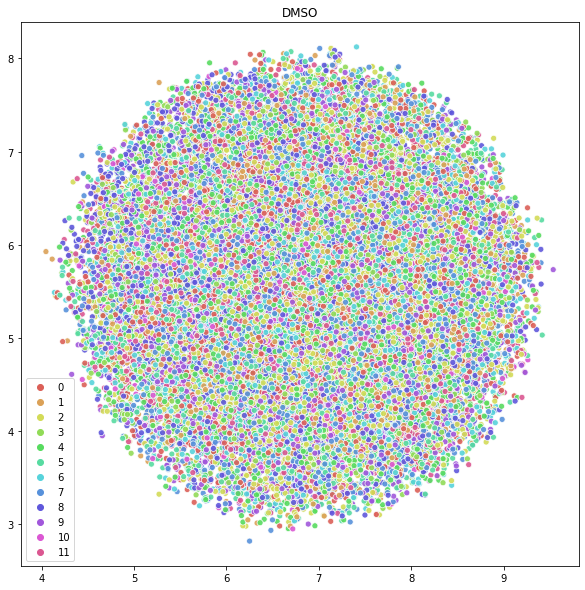

In [61]:
plt.figure(figsize=(10,10))
sns.scatterplot(z_2d[:,0], z_2d[:,1], alpha=0.9, hue=categorical_labels.cat.codes, palette=sns.hls_palette(12))
plt.title('DMSO')
plt.show()

### Experimental Cells
Please ignore

In [ ]:
img, _ = next(iter(val_data))
print(img.shape)
print(torch.max(img[0]))
print(torch.max(img[0][0]))
print(torch.max(img[0][1]))
print(torch.max(img[0][2]))

In [ ]:
x = img[0:100].to(device)
recon, mu, logvar = model.forward(x)

In [ ]:
img[1:2] + img[2:3]*0.25

In [ ]:
interpolated = None
base_a = None
base_b = None
with torch.no_grad():
    cell_a = img[48:49].to(device)
    cell_b = img[50:51].to(device)

    mu_a, sigma_a = model.encode(cell_a)
    mu_b, sigma_b = model.encode(cell_b)

    z_a = model.reparameterize(mu_a, sigma_a)
    z_b = model.reparameterize(mu_b, sigma_b)

    z_diff = z_b - z_a
    recon_a = model.decode(z_a)
    recon_25 = model.decode(z_a + (z_diff * 0.25))
    recon_50 = model.decode(z_a + (z_diff * 0.50))
    recon_75 = model.decode(z_a + (z_diff * 0.75))
    recon_b = model.decode(z_b)
    interpolated = torch.cat((recon_a, recon_25, recon_50, recon_75, recon_b), dim=0).cpu()
    base_a = cell_a.cpu()
    base_b = cell_b.cpu()

In [ ]:
imshow(torchvision.utils.make_grid(torch.cat((base_a, base_b), dim=0)))

In [ ]:
imshow(torchvision.utils.make_grid(interpolated))
plt.show()

In [ ]:
loss, mse, kld = loss_function(recon, x, mu, logvar)
kld

In [ ]:
torch.mean((-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)))

In [ ]:
torch.sum(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

In [ ]:
-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

In [ ]:
mse

In [ ]:
# MSE
torch.mean(torch.mean((x - recon).pow(2), dim=(1,2,3)))

In [ ]:
# Mean of sum of squared errors
torch.mean(torch.sum((x - recon).pow(2), dim=(1,2,3)))

In [ ]:
torch.sum((x - recon).pow(2), dim=(1,2,3))

In [ ]:
recon

In [ ]:
F.mse_loss(recon, x, reduction='sum')

# Extra

The cell below calculates the MEAN and STD of the data set so it can be normalized properly

In [ ]:
image_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))

loader = data.DataLoader(
    image_dataset,
    batch_size=128,
    num_workers=0,
    pin_memory=True,
    shuffle=False
)


mean = 0.
std = 0.
nb_samples = 0.
for dat, _ in loader:
    batch_samples = dat.size(0)
    dat = dat.view(batch_samples, dat.size(1), -1)
    mean += dat.mean(2).sum(0)
    std += dat.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples
print("mean: ", mean)
print("std: ", std)